In [1]:
import numpy as np
import pandas as pd
import itertools
import os
import errno
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import astropy.units as units
import astropy.constants as constants
from decimal import Decimal

colors = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']

# Define directory-generating function
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
params = {'legend.fontsize': 20,
     'figure.figsize': (7, 7),
     'axes.titlesize':25,
     'axes.labelsize': 20,
     'xtick.labelsize':15,
     'ytick.labelsize':15, 
     'axes.grid': True, 
     'legend.frameon': True,
     'legend.framealpha': 0.5}

plt.rcParams.update(params)


# Conversion factors to go from G=1 Msun Rsun units to kms

t_conv = np.sqrt((constants.R_sun**3)/(constants.M_sun*constants.G))
print('Conversion factor for time: %0.2E seconds' % Decimal(t_conv.value))

v_conv = 1/np.sqrt(constants.R_sun/(constants.M_sun*constants.G))
print('Conversion factor for velocity: %0.2E meters per second' % Decimal(v_conv.value))

Rsun_to_AU = units.Rsun.to(units.AU)
print('Conversion factor for Rsun to AU: %0.2E' % Decimal(Rsun_to_AU))

Conversion factor for time: 1.59E+03 seconds
Conversion factor for velocity: 4.37E+05 meters per second
Conversion factor for Rsun to AU: 4.65E-03


### 4Body movie

In [29]:
# Plot single track
bpath = './'

# find dimensionality of data
n_part=int(len(pd.read_table(bpath+'Nbody_positions.dat', delim_whitespace=True, nrows=1).T)/3)

# for column names, legends, and axes labels
numbers=np.arange(n_part)+1
numbers=[str(i) for i in numbers]
part_labels=['x','y','z']
names=map(''.join, itertools.product(numbers,part_labels))
names=[i[::-1] for i in names]
names = np.reshape(names, (n_part,3))
colors=['b','r','g','m']

### load data
pos=pd.read_table(bpath+'Nbody_positions.dat', delim_whitespace=True, names=names.flatten())
vel=pd.read_table(bpath+'Nbody_velocities.dat', delim_whitespace=True, names=names.flatten())
time=pd.read_table(bpath+'Nbody_times.dat', delim_whitespace=True, usecols=[0], squeeze=True, header=None)
ICs=pd.read_table(bpath+'Nbody_initial_conditions.dat', delim_whitespace=True, index_col=None, names=['M','R','x','y','z','vx','vy','vz'])

# convert data to AU and seconds
for p_key, v_key in zip(pos.keys(), vel.keys()):
    pos[p_key] = pos[p_key]*Rsun_to_AU
    vel[v_key] = vel[v_key]*v_conv * units.m.to(units.km)
time = time*t_conv * units.s.to(units.yr)

# add time column to positions and velocities
pos['t'] = time
vel['t'] = time

print('length of data: %i' % len(pos))


length of data: 1359071


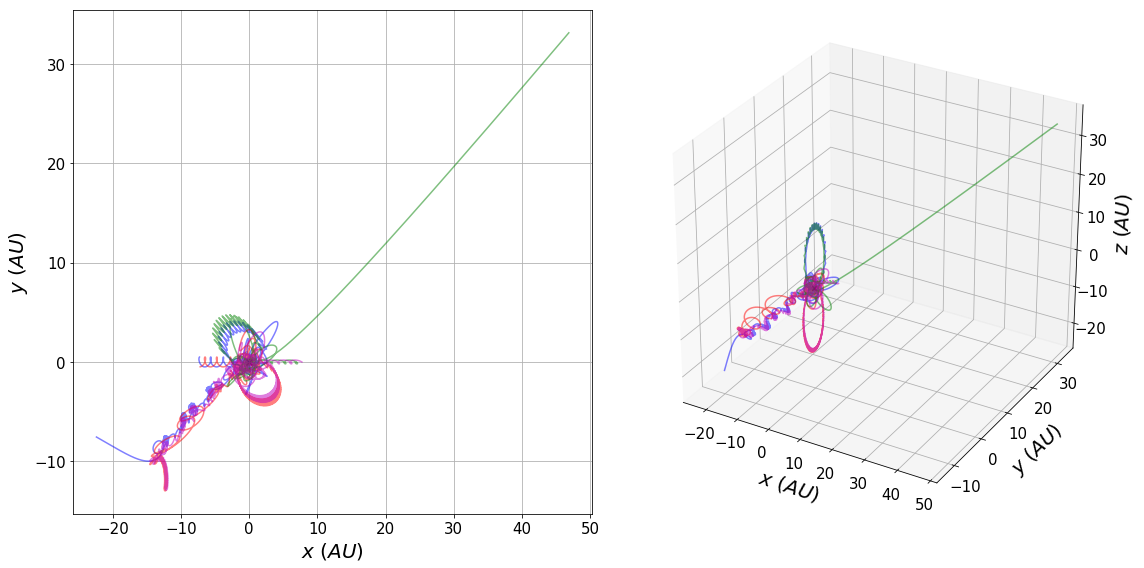

In [39]:
### Plot the entire evolution between 'b' and 'f'
lw=2

# set bounds of steps to plot (use static plot above for guidence)
b=28000
f=150000

fig = plt.figure(figsize=(16,8))

# 2d plot
ax1 = fig.add_subplot((121))
ax1.set_xlabel(r'$x\ (AU)$')
ax1.set_ylabel(r'$y\ (AU)$')
ax1.grid(True)
ax1.scatter([0],[0],marker='x',color='k')

for i, dim in enumerate(names):
    ax1.plot((pos[dim[0]])[b:f],(pos[dim[1]])[b:f], color=colors[i], label='particle '+str(i+1), alpha=0.5)


# 3d plot
ax2 = fig.add_subplot((122), projection='3d')
ax2.set_xlabel(r'$x\ (AU)$', labelpad=10)
ax2.set_ylabel(r'$y\ (AU)$', labelpad=10)
ax2.set_zlabel(r'$z\ (AU)$', labelpad=10)
ax2.grid(True)
ax2.scatter([0],[0],[0],marker='x',color='k')

for i, dim in enumerate(names):
    ax2.plot((pos[dim[0]])[b:f],(pos[dim[1]])[b:f], (pos[dim[2]])[b:f], color=colors[i], label='particle '+str(i+1), alpha=0.5)

plt.tight_layout()

In [40]:
# cut the tracks accordingly

pos = pos.iloc[b:f]
vel = vel.iloc[b:f]
time = time.iloc[b:f]

In [41]:
### path for output images ###
path = 'movie_files/4body/exchange_ionization/'

### parameters that go into the movie ###
tot_steps=1000
ss=20
lw=2
colors=['b','r','g','m']
labels=['m11','m12','m21','m22']
CoM_idxs=[1,3]   # follow center of mass of these particles

### step spacing ###
# spend 't_fine_perc' percentage of the steps on the part of the track from 't_fine_step' onward
t_fine_perc=0
t_fine_step=1

if t_fine_perc != 0:
    steps1=np.linspace(time.min(), t_fine*time.max(), t_fine_perc*tot_steps)
    steps2=np.linspace(t_fine*time.max(), time.max(), (1-t_fine_perc)*tot_steps)
    steps=np.concatenate((steps1,steps2[1:]))  # otherwise we repeat the last step
else:
    steps=np.linspace(time.min(), time.max(), tot_steps)

### center of mass definitions ###
def CoM(idxs, step, M, pos, Z=False):
    M = np.asarray(M)[idxs]
    X = np.asarray(pos[['x1','x2','x3','x4']]).T[idxs]
    x = X[:,step]
    CM_x = np.sum(x*M)/np.sum(M)
    Y = np.asarray(pos[['y1','y2','y3','y4']]).T[idxs]
    y = Y[:,step]
    CM_y = np.sum(y*M)/np.sum(M)
    if Z==True:
        Z = np.asarray(pos[['z1','z2','z3','z4']]).T[idxs]
        z = Z[:,step]
        CM_z = np.sum(z*M)/np.sum(M)
        return CM_x, CM_y, CM_z
    else:
        return CM_x, CM_y


#################
### MAIN LOOP ###
#################
for i in range(len(steps)-1):
#for i in np.arange(945,1000):
    if i%50==0:
        print('Current Step: %i' % i)
    
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot((121))
    ax1.set_xlabel(r'$x\ (AU)$')
    ax1.set_ylabel(r'$y\ (AU)$')
    ax1.grid(True)
    ax1.scatter([0],[0],marker='x',color='k')
    
    # scale axis by initial position
    # Follow the CM of subset of the bodies
    CM_x,CM_y = CoM(CoM_idxs, i, ICs['M'], pos, Z=False)
    
    # Each step we can determine the largest distances, set the limits accordinly...
    
    for j, dim in enumerate(names):
        # plot particle
        ax1.scatter(np.asarray(pos[dim[0]])[(time>steps[i])&(time<steps[i+1])][-1],\
                    np.asarray(pos[dim[1]])[(time>steps[i])&(time<steps[i+1])][-1], color=colors[j], \
                    label=(labels[j]+'=%.1f M$_{\odot}$' % ICs['M'].iloc[j]), marker='o', s=ss*float(ICs['M'].iloc[j]/ICs['M'].max())**2)
        
        # dimly plot full prior trajectory
        ax1.plot(np.asarray(pos[dim[0]])[(time<steps[i+1])], \
                 np.asarray(pos[dim[1]])[(time<steps[i+1])], lw=lw, color=colors[j], alpha=0.1)
        
        # now plot more recent trajectory in darker colors
        if i>0:
            ax1.plot(np.asarray(pos[dim[0]])[(time>steps[i])&(time<steps[i+1])], \
                     np.asarray(pos[dim[1]])[(time>steps[i])&(time<steps[i+1])], lw=lw, color=colors[j])
        
        if i>1:
            ax1.plot(np.asarray(pos[dim[0]])[(time>steps[i-1])&(time<steps[i])], \
                     np.asarray(pos[dim[1]])[(time>steps[i-1])&(time<steps[i])], lw=lw, color=colors[j], alpha=0.5)
            
        if i>2:
            ax1.plot(np.asarray(pos[dim[0]])[(time>steps[i-2])&(time<steps[i-1])], \
                     np.asarray(pos[dim[1]])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color=colors[j], alpha=0.3)

    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)



    ax2 = fig.add_subplot((122), projection='3d')
    ax2.set_xlabel(r'$x\ (AU)$', labelpad=10)
    ax2.set_ylabel(r'$y\ (AU)$', labelpad=10)
    ax2.set_zlabel(r'$z\ (AU)$', labelpad=10)
    ax2.grid(True)
    ax2.scatter([0],[0],[0],marker='x',color='k')
    
    # Follow the CM of 2 of the bodies
    CM_x,CM_y,CM_z = CoM(CoM_idxs, i, ICs['M'], pos, Z=True)
    
    for j, dim in enumerate(names):
        # plot particle
        ax2.scatter(np.asarray(pos[dim[0]])[(time>steps[i])&(time<steps[i+1])][-1],\
                    np.asarray(pos[dim[1]])[(time>steps[i])&(time<steps[i+1])][-1], \
                    np.asarray(pos[dim[2]])[(time>steps[i])&(time<steps[i+1])][-1], color=colors[j], \
                    label=(labels[j]+'=%.1f M$_{\odot}' % ICs['M'].iloc[j]), marker='o', s=ss*float(ICs['M'].iloc[j]/ICs['M'].max())**2)
        
        # dimly plot full prior trajectory
        ax2.plot(np.asarray(pos[dim[0]])[(time<steps[i+1])], \
                 np.asarray(pos[dim[1]])[(time<steps[i+1])], \
                 np.asarray(pos[dim[2]])[(time<steps[i+1])], lw=lw, color=colors[j], alpha=0.1)
        
        # now plot more recent trajectory in darker colors
        if i>0:
            ax2.plot(np.asarray(pos[dim[0]])[(time>steps[i])&(time<steps[i+1])], \
                 np.asarray(pos[dim[1]])[(time>steps[i])&(time<steps[i+1])], \
                 np.asarray(pos[dim[2]])[(time>steps[i])&(time<steps[i+1])], lw=lw, color=colors[j])
        
        if i>1:
            ax2.plot(np.asarray(pos[dim[0]])[(time>steps[i-1])&(time<steps[i])], \
                 np.asarray(pos[dim[1]])[(time>steps[i-1])&(time<steps[i])], \
                 np.asarray(pos[dim[2]])[(time>steps[i-1])&(time<steps[i])], lw=lw, color=colors[j], alpha=0.5)
            
        if i>2:
            ax2.plot(np.asarray(pos[dim[0]])[(time>steps[i-2])&(time<steps[i-1])], \
                 np.asarray(pos[dim[1]])[(time>steps[i-2])&(time<steps[i-1])], \
                 np.asarray(pos[dim[2]])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color=colors[j], alpha=0.3)

    plt.tight_layout(rect=[0.06, 0.00, 0.94, 0.88])
    ax2.set_title('t = %.1E yr' % (np.asarray(time)[(time>steps[i])&(time<steps[i+1])][-1]), fontsize=25)
    
    mkdir_p(path)
    plt.savefig(path+str(i).zfill(4))
    plt.close()

Current Step: 0
Current Step: 50
Current Step: 100
Current Step: 150
Current Step: 200
Current Step: 250
Current Step: 300
Current Step: 350
Current Step: 400
Current Step: 450
Current Step: 500
Current Step: 550
Current Step: 600
Current Step: 650
Current Step: 700
Current Step: 750
Current Step: 800
Current Step: 850
Current Step: 900
Current Step: 950


### 2Body Movie

In [ ]:
# Plot single track
bpath = './'

# find dimensionality of data
n_part=int(len(pd.read_table(bpath+'Nbody_positions.dat', delim_whitespace=True, nrows=1).T)/3)

# for column names, legends, and axes labels
numbers=np.arange(n_part)+1
numbers=[str(i) for i in numbers]
part_labels=['x','y','z']
names=map(''.join, itertools.product(numbers,part_labels))
names=[i[::-1] for i in names]
names = np.reshape(names, (n_part,3))
colors=['b','r','g','m']

### load data
pos=pd.read_table(bpath+'Nbody_positions.dat', delim_whitespace=True, names=names.flatten())
vel=pd.read_table(bpath+'Nbody_velocities.dat', delim_whitespace=True, names=names.flatten())
time=pd.read_table(bpath+'Nbody_times.dat', delim_whitespace=True, usecols=[0], squeeze=True, header=None)
ICs=pd.read_table(bpath+'Nbody_initial_conditions.dat', delim_whitespace=True, index_col=None, names=['M','R','x','y','z','vx','vy','vz'])

# add time column to positions and velocities
pos['t'] = time
vel['t'] = time

print('length of data: %i' % len(pos))


In [83]:
n_part=2
ax_scale=1.0 # scale the axis from the initial separation value

r_start = 0.009138866615998274
Rcirc_10Hz = 0.0013561886556633681

In [85]:
tot_steps=1000
lw=3

steps=np.linspace(0, time.max(), tot_steps)

path = '2body_movie/'

def CoM_2d(m1,m2,x1,y1,x2,y2):
    CM_x = (x1*m1 + x2*m2)/(m1+m2)
    CM_y = (y1*m1 + y2*m2)/(m1+m2)
    return CM_x, CM_y

for i in range(len(steps)-1):
    
    if i%50==0:
        print('step %i' % i)
    
    fig = plt.figure(figsize=(9,8))
    # set up axes
    ax1 = fig.add_subplot((111))
    ax1.set_xlim(-0.01, 0.01)
    ax1.set_ylim(-0.01, 0.01)
    ax1.set_xlabel(r'x (R$_{\odot}$)', fontsize=20)
    ax1.set_ylabel(r'y (R$_{\odot}$)', fontsize=20)
    ax1.grid(True)
    ax1.ticklabel_format(style='sci',scilimits=(-1,1),axis='both')
    
    ax1.scatter(np.asarray(pos['x1'])[(time>steps[i])&(time<steps[i+1])],\
                np.asarray(pos['y1'])[(time>steps[i])&(time<steps[i+1])], color='b', \
                marker='o', s=20)
    ax1.scatter(np.asarray(pos['x2'])[(time>steps[i])&(time<steps[i+1])],\
                np.asarray(pos['y2'])[(time>steps[i])&(time<steps[i+1])], color='r', \
                marker='o', s=20)
    
    ax1.plot(np.asarray(pos['x1'])[(time<steps[i+1])],np.asarray(pos['y1'])[(time<steps[i+1])], lw=lw, color='b', alpha=0.1)
    ax1.plot(np.asarray(pos['x2'])[(time<steps[i+1])],np.asarray(pos['y2'])[(time<steps[i+1])], lw=lw, color='r', alpha=0.1)

    if i>0:
        ax1.plot(np.asarray(pos['x1'])[(time>steps[i])&(time<steps[i+1])],\
                 np.asarray(pos['y1'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='b')
        ax1.plot(np.asarray(pos['x2'])[(time>steps[i])&(time<steps[i+1])],\
                 np.asarray(pos['y2'])[(time>steps[i])&(time<steps[i+1])], lw=lw, color='r')

    if i>1:
        ax1.plot(np.asarray(pos['x1'])[(time>steps[i-1])&(time<steps[i])],\
                 np.asarray(pos['y1'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='b', alpha=0.5)
        ax1.plot(np.asarray(pos['x2'])[(time>steps[i-1])&(time<steps[i])],\
                 np.asarray(pos['y2'])[(time>steps[i-1])&(time<steps[i])], lw=lw, color='r', alpha=0.5)

    if i>2: 
        ax1.plot(np.asarray(pos['x1'])[(time>steps[i-2])&(time<steps[i-1])],\
                 np.asarray(pos['y1'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='b', alpha=0.3)
        ax1.plot(np.asarray(pos['x2'])[(time>steps[i-2])&(time<steps[i-1])],\
                 np.asarray(pos['y2'])[(time>steps[i-2])&(time<steps[i-1])], lw=lw, color='r', alpha=0.3)
        
    
    theta_vals = np.linspace(0,2*np.pi,1000)
    ax1.scatter([0],[0],marker='x',color='k', label=None)
    x_vals = r_start*np.cos(theta_vals)
    y_vals = r_start*np.sin(theta_vals)
    ax1.plot(x_vals, y_vals, color='k', linestyle=':', alpha=0.5, label=r'R$_{\rm apo,init}$')

    x_vals_10Hz = Rcirc_10Hz*np.cos(theta_vals)
    y_vals_10Hz = Rcirc_10Hz*np.sin(theta_vals)
    ax1.plot(x_vals_10Hz, y_vals_10Hz, color='k', linestyle='--', label=r'R$_{\rm 10Hz}$')

    #ax1.set_title('t = %i' % time[i], fontsize=20)
    ax1.legend(loc='upper right')
    plt.tight_layout()
    
    mkdir_p('movie_files/'+path)
    plt.savefig('movie_files/'+path+str(i).zfill(4))
    plt.close()

step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
step 400
step 450
step 500
step 550
step 600
step 650
step 700
step 750
step 800
step 850
step 900
step 950
